In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import pandas as pd
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
# from nltk.stem.wordnet import WordNetLemmatizer as lemmatizer
import matplotlib.colors as mcolors
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'hotel', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
period_name = 'covid'
k = 4

In [3]:
df = pd.read_csv(f'{period_name}.csv')
df.head()

,Unnamed: 0,date,review_text,rating
0,87,2021-10-01,Our first of two stops in Ibiza and our stay a...,5
1,88,2021-10-01,"We spent 5 amazing days, enjoying the pool, th...",5
2,89,2021-10-01,"From the welcome drink on arrival, to the leav...",5
3,90,2021-10-01,We are a couple of days in to our fantastic ho...,5
4,91,2021-10-01,We had an amazing team at the 7 pines. We rece...,5


In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['review_text'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['our', 'first', 'of', 'two', 'stops', 'in', 'ibiza', 'and', 'our', 'stay', 'at', 'pines', 'was', 'great', 'the', 'views', 'and', 'location', 'are', 'incredible', 'the', 'hotel', 'was', 'incredibly', 'accommodating', 'and', 'we', 'would', 'definitely', 'return', 'the', 'tasting', 'menu', 'at', 'the', 'view', 'is', 'must', 'and', 'enrique', 'deserves', 'mention']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.031*"day" + 0.023*"time" + 0.016*"check" + 0.014*"give" + 0.013*"first" + '
  '0.013*"guest" + 0.013*"covid" + 0.013*"book" + 0.012*"stay" + 0.010*"next"'),
 (1,
  '0.050*"music" + 0.049*"relax" + 0.039*"provide" + 0.039*"kind" + '
  '0.038*"professional" + 0.029*"luxury" + 0.025*"attention" + 0.023*"play" + '
  '0.021*"class" + 0.021*"detail"'),
 (2,
  '0.052*"room" + 0.028*"pool" + 0.017*"night" + 0.013*"order" + '
  '0.013*"restaurant" + 0.012*"drink" + 0.012*"bar" + 0.011*"food" + '
  '0.011*"bit" + 0.010*"water"'),
 (3,
  '0.033*"stay" + 0.033*"staff" + 0.032*"great" + 0.031*"room" + '
  '0.024*"service" + 0.020*"pool" + 0.018*"amazing" + 0.017*"view" + '
  '0.016*"really" + 0.016*"restaurant"'),
 (4,
  '0.040*"people" + 0.032*"work" + 0.028*"big" + 0.026*"kid" + 0.023*"minute" '
  '+ 0.022*"club" + 0.021*"enough" + 0.021*"child" + 0.019*"door" + '
  '0.019*"call"'),
 (5,
  '0.086*"back" + 0.056*"clean" + 0.035*"evening" + 0.028*"family" + '
  '0.028*"price" + 0.027*"eve

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_29648\1516627226.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_29648\1516627226.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_29648\1516627226.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\S

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5386,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[first, stop, ibiza, stay, pine, great, view, location, incredible, incredibly, accommodate, def..."
1,1,3,0.9513,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[spend, amazing, day, enjoy, pool, restaurant, breathtaking, view, sunset, definitely, place, st..."
2,2,3,0.6482,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[drink, arrival, leave, gift, receive, checkout, whole, experience, pine, incredible, stay, hone..."
3,3,3,0.8352,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[couple, day, fantastic, holiday, pine, welcome, drink, tour, friendly, fantastic, host, recepti..."
4,4,3,0.9622,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[amazing, team, pine, receive, upgrade, welcome, friendly, attentive, staff, villa, stay, modern..."
5,5,3,0.4836,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[pricy, worth, great, resort, individual, house, pool, fancy, lounge, bar, pool, family, adult, ..."
6,6,3,0.6783,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[location, pine, superb, situate, overlook, stunning, mystical, island, rd, magnetic, place, ear..."
7,7,5,0.5460,"back, clean, evening, family, price, ever, safe, spacious, new, name","[fiance, dine, view, pine, safe, exquisite, emotional, culinary, experience, ever, choose, cours..."
8,8,5,0.5118,"back, clean, evening, family, price, ever, safe, spacious, new, name","[recently, stay, pine, night, magnificent, experience, picture, accurate, view, breathtaking, se..."
9,9,3,0.8538,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[hear, report, pine, expectation, high, disappointed, stunning, location, exceptional, facility,..."


In [ ]:
df_dominant_topic.sample(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7607,7607,3,0.6504,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[real, classic, staff, honestly, enough, food, absolutely, stunning, well, present, room, incred..."
402,402,2,0.3644,"room, pool, night, order, restaurant, drink, bar, food, bit, water","[check, give, wrist, band, microchip, give, access, room, download, book, restaurant, well, meal..."
2468,2468,3,0.5349,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[excellent, receive, welcome, reception, front, house, team, staff, encounter, stay, friendly, h..."
6919,6919,3,0.6791,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[opportunity, lunch, sea, restaurant, puente_romano, partner, friend, really, impress, new, menu..."
8170,8170,3,0.4172,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[boutique, luxury, attention, detail, well, locate, beautiful, lobby, restaurant, terrace, smart..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8033,"day, time, check, give, first, guest, covid, book, stay, next","[spend, wonderful, holiday, princesa_yaiza, year, book, holiday, close, due, corona_virus, holid..."
1,1,0.4446,"music, relax, provide, kind, professional, luxury, attention, play, class, detail","[positive, impression, suprise, attention, detail, swiss, watch, single, breakfast, tasty, supri..."
2,2,0.8014,"room, pool, night, order, restaurant, drink, bar, food, bit, water","[poor, quality, service, poor, food, restaurant, unfriendly, staff, overprice, worth, money, pay..."
3,3,0.9691,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[love, stay, quiet, peaceful, place, beautiful, interior, staff, helpful, great, spa, lovely, vi..."
4,4,0.5503,"people, work, big, kid, minute, club, enough, child, door, call","[modern, hip, art, space, room, small, side, real, door, separate, shower, toilet, area, rest, r..."
5,5,0.5460,"back, clean, evening, family, price, ever, safe, spacious, new, name","[fiance, dine, view, pine, safe, exquisite, emotional, culinary, experience, ever, choose, cours..."


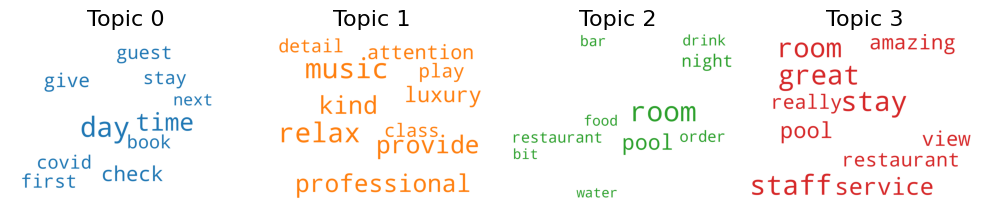

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, k, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
# plt.savefig(f'{period_name}_topics_words.jpg', bbox_inches='tight', dpi=800)
plt.show()

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_29648\2517350725.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


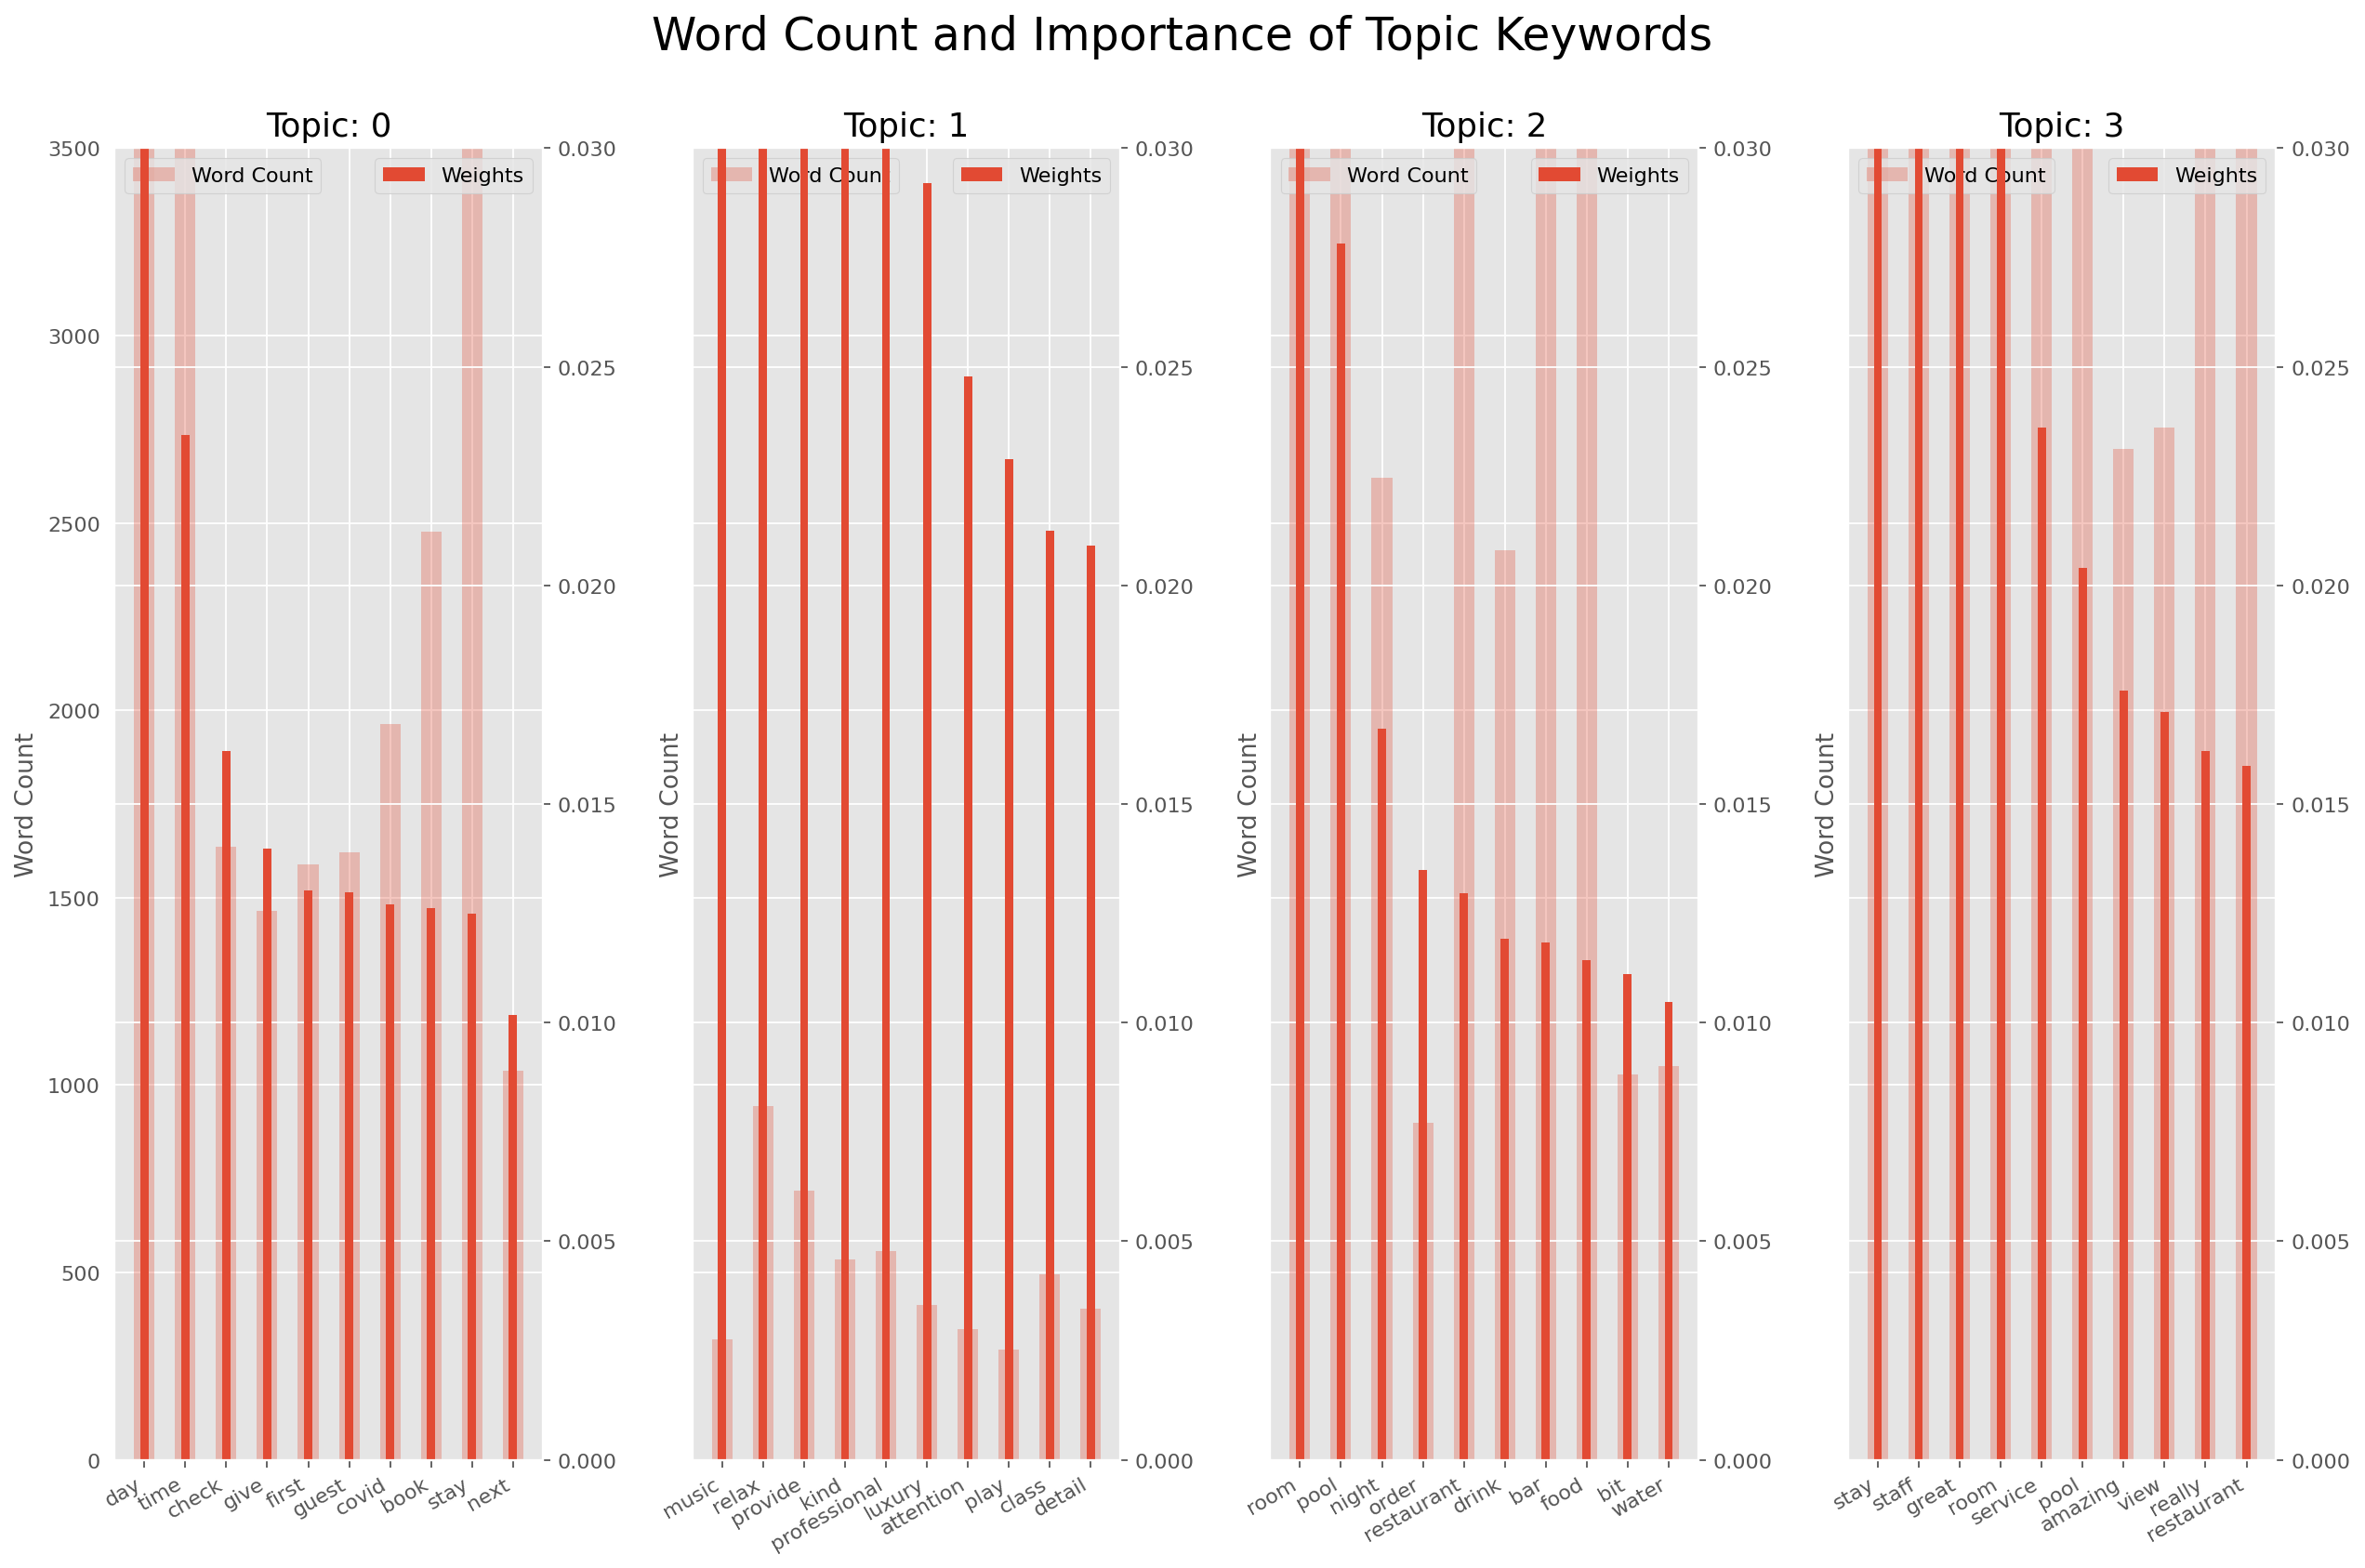

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

plt.style.use('ggplot')

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, k, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], width=0.2, label='Weights')
    ax.set_ylabel('Word Count')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

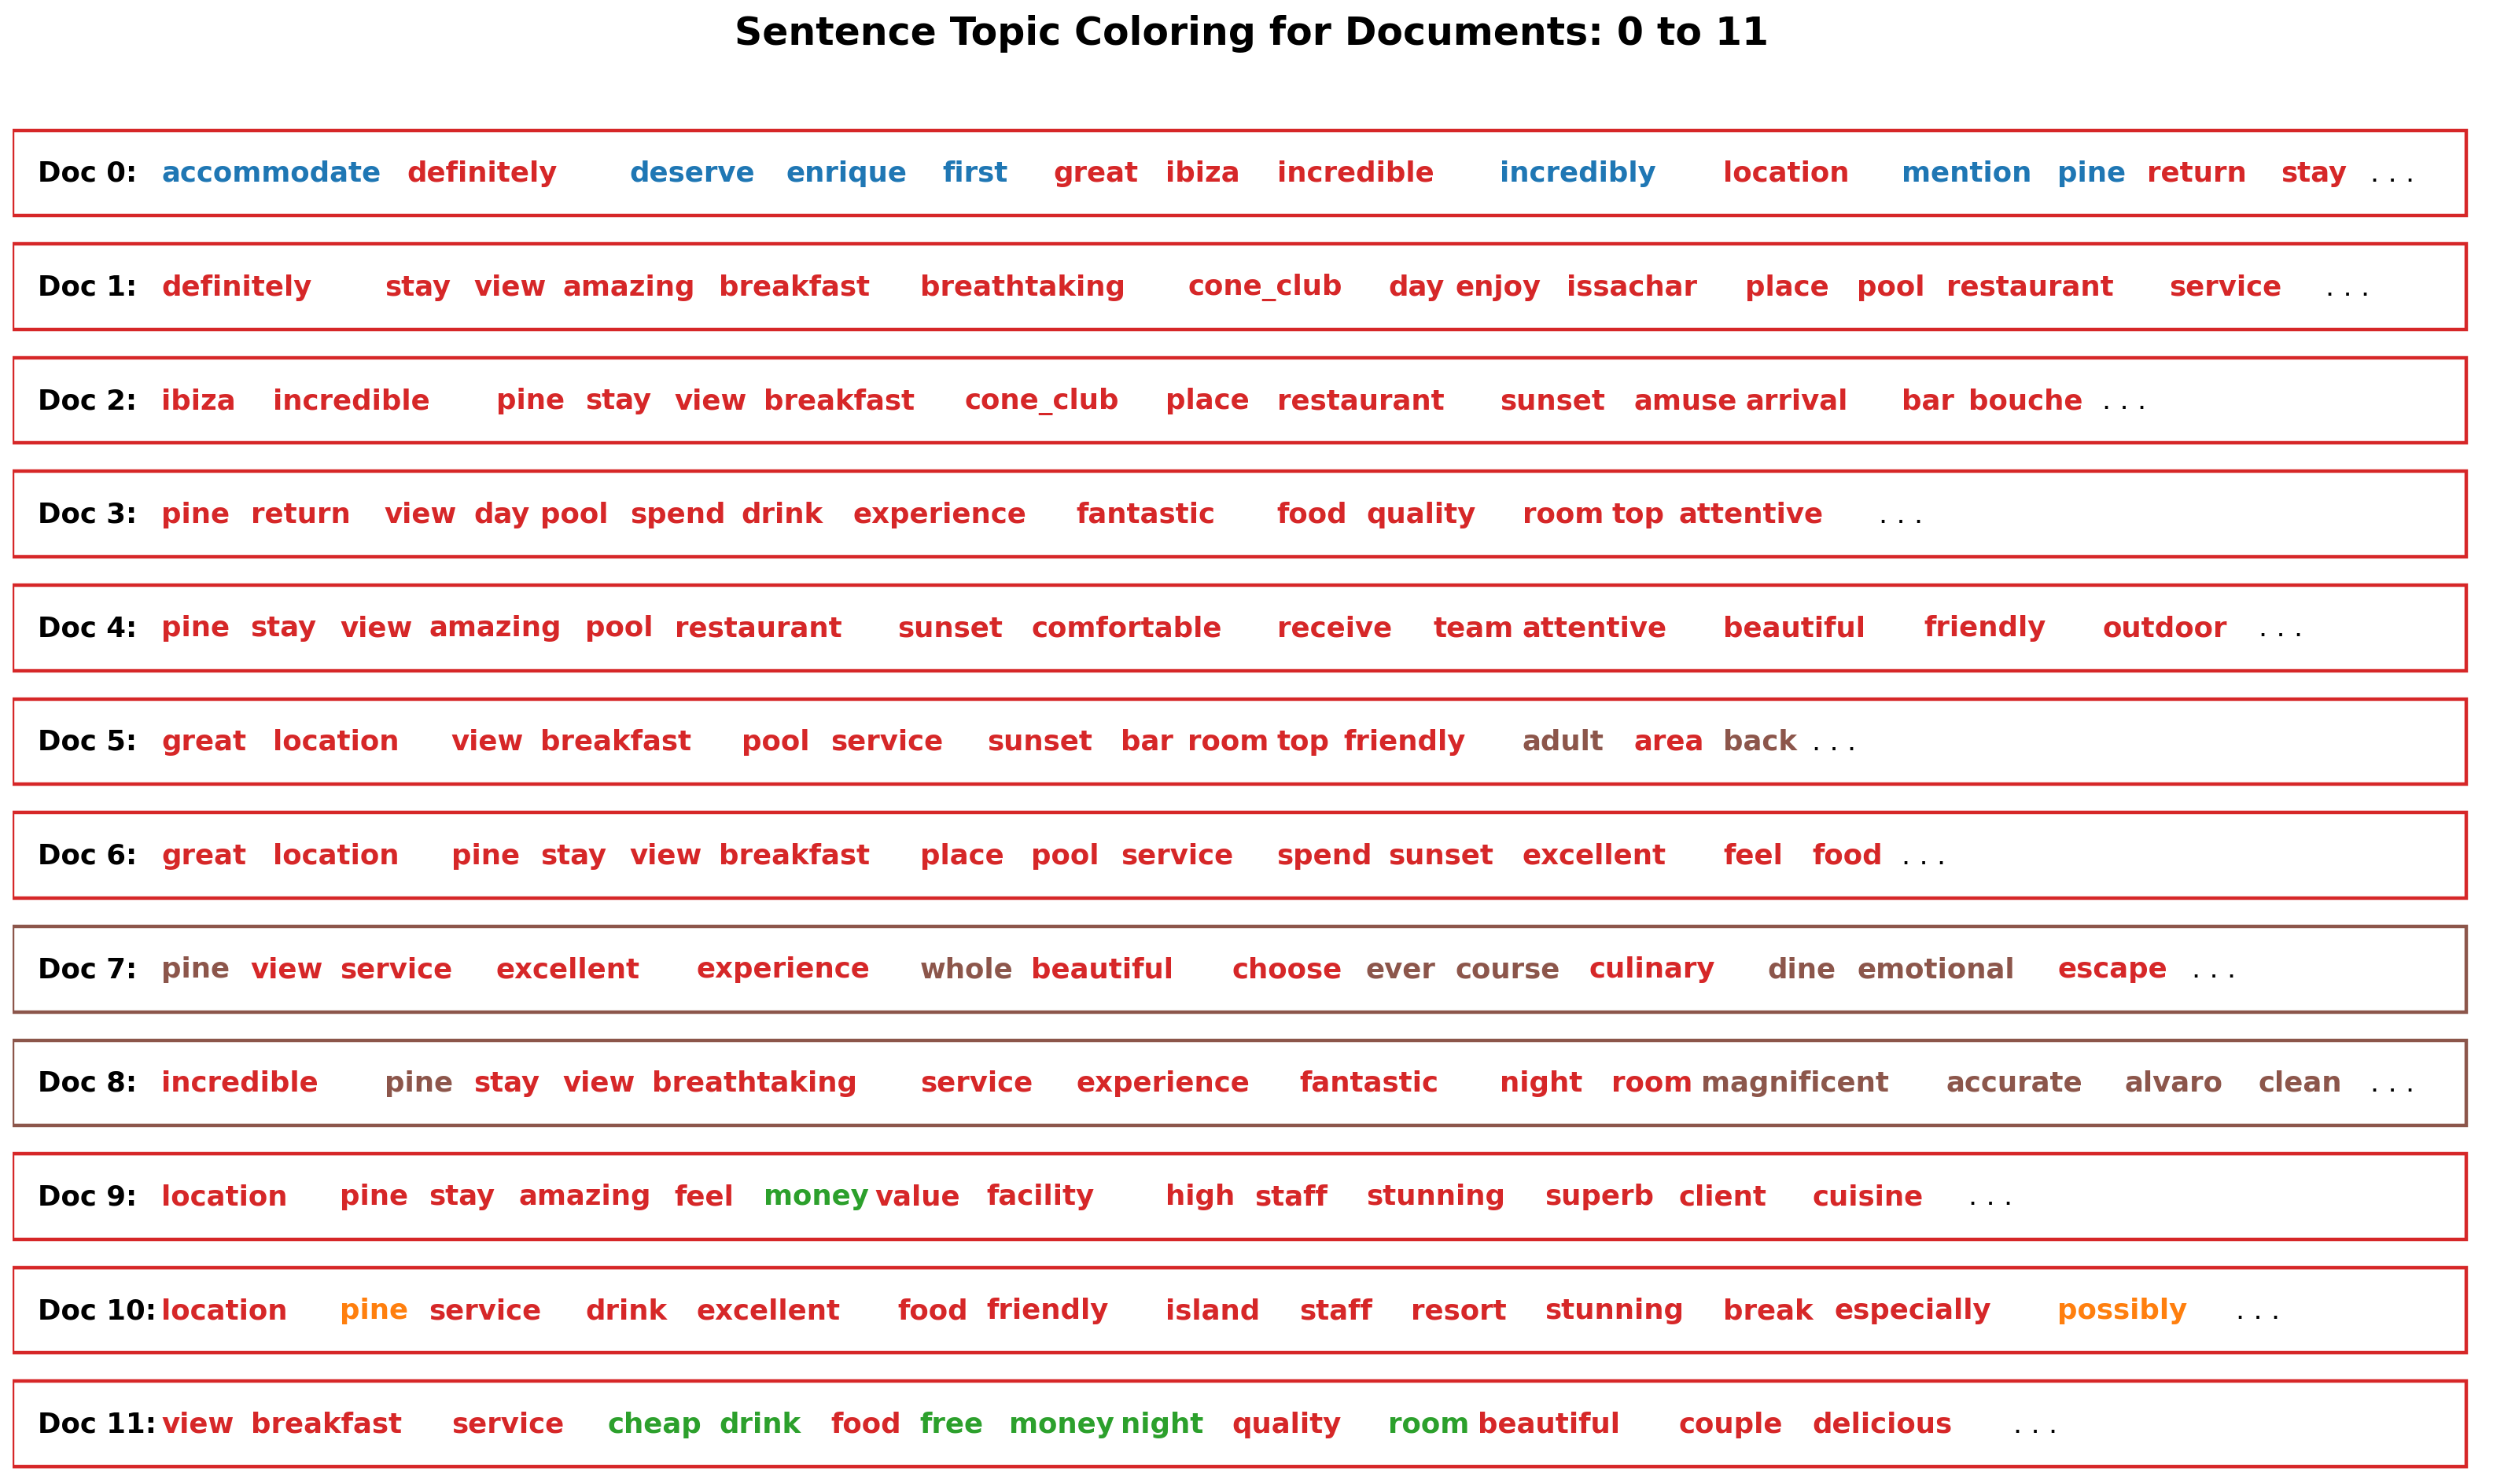

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [ ]:
raw_df = pd.read_csv(f'{period_name}.csv')
raw_df.head()

,Unnamed: 0,date,review_text,rating
0,87,2021-10-01,"Our first of two stops in Ibiza and our stay at 7Pines was great, the views and location are inc...",5
1,88,2021-10-01,"We spent 5 amazing days, enjoying the pool, the restaurants and the breathtaking view, even more...",5
2,89,2021-10-01,"From the welcome drink on arrival, to the leaving gift we received at checkout - the whole exper...",5
3,90,2021-10-01,We are a couple of days in to our fantastic holiday at the 7pines. We were welcomed with a drink...,5
4,91,2021-10-01,"We had an amazing team at the 7 pines. We received an upgrade, were welcomed by very friendly an...",5


In [ ]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5386,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[first, stop, ibiza, stay, pine, great, view, location, incredible, incredibly, accommodate, def..."
1,1,3,0.9513,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[spend, amazing, day, enjoy, pool, restaurant, breathtaking, view, sunset, definitely, place, st..."
2,2,3,0.6482,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[drink, arrival, leave, gift, receive, checkout, whole, experience, pine, incredible, stay, hone..."
3,3,3,0.8352,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[couple, day, fantastic, holiday, pine, welcome, drink, tour, friendly, fantastic, host, recepti..."
4,4,3,0.9622,"stay, staff, great, room, service, pool, amazing, view, really, restaurant","[amazing, team, pine, receive, upgrade, welcome, friendly, attentive, staff, villa, stay, modern..."


In [ ]:
merged_df = raw_df.merge(df_dominant_topic, how='inner', left_on="Unnamed: 0", right_on="Document_No").drop(["Unnamed: 0", "Document_No", "Text"], axis=1)
# merged_df.to_csv(f'{period_name}.csv')
merged_df.sample(10)

,date,review_text,rating,Dominant_Topic,Topic_Perc_Contrib,Keywords
325,2020-08-01,My fiancé and I stayed at the Bahia last week and really enjoyed it. Like everyone we had concer...,5,3,0.4818,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
147,2021-10-01,It was a little while ago I stayed - I've been meaning to write! to say what a gorgeous hotel wi...,5,3,0.6626,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
54,2021-07-01,Paradise for parents with Kids\nUndoubtedly the best views on the island\nPhenomenal food\nLovel...,5,2,0.3788,"room, pool, night, order, restaurant, drink, bar, food, bit, water"
324,2020-09-01,I visited this hotel for many years. On what I consider to be my final stay we were down graded ...,1,3,0.6965,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
154,2021-04-01,Due to circumstances you all know we could not travel far in order to celebrate my birthday.\nWe...,5,3,0.3259,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
297,2021-08-01,We have returned to this hotel for the second time and we love it. The style and beauty of the h...,5,3,0.4371,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
149,2021-08-01,"Superior service, best-in-class stuff, and lovely Scandinavian design, both minimalistic and coz...",5,2,0.3014,"room, pool, night, order, restaurant, drink, bar, food, bit, water"
199,2020-08-01,We are now enjoying our 3rd Short stay at the truly amazing Anantara Villa Padierna despite havi...,5,3,0.5305,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
19,2021-09-01,"We had dinner here which was lovely, food was great, but what made our experience even better wa...",5,3,0.7804,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"
305,2021-07-01,We stayed end of June 2021 when the hotel was not yet full. Lovely experience and very special p...,5,3,0.4343,"stay, staff, great, room, service, pool, amazing, view, really, restaurant"


In [ ]:
merged_df.to_csv(f'merged_topics_{period_name}.csv')

In [ ]:
def get_freq(texts:list[list]):
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    return frequency

freq_dict = get_freq(data_ready)

In [ ]:
def make_plot(freq_dict:dict, cmap:str="Pastel1"):
    # Make a circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    # Create wordcloud object
    wc = WordCloud(width = 1000, height = 500, mask=mask, collocations=False, colormap=plt.cm.get_cmap(cmap)).generate_from_frequencies(freq_dict)
    # Plot the wordcloud
    plt.figure(figsize=(50,30))
    plt.imshow(wc)
    plt.axis("off")
    #plt.show()
    plt.savefig(f'{period_name}_wordcloud.jpg', bbox_inches='tight', dpi=800)
    plt.close()
make_plot(freq_dict)